# Actividad 1

## Requisitos

- Habitación de MxN espacios.
- Número de agentes.
- Porcentaje de celdas inicialmente sucias.
- Tiempo máximo de ejecución.

## Instrucciones

- Inicializa las celdas sucias (ubicaciones aleatorias).
- Todos los agentes empiezan en posiciones aleatorias.
- En cada paso de tiempo:
    - Si la celda está sucia, entonces aspira.
    - Si la celda está limpia, 
        - El agente elije mover a una nueva celda, usando esta selección: norte, este, sur, oeste.
        - El agente se moverá a esa celda siempre y cuando no la haya visitado antes. 
        - Si no tiene opciones para moverse, el agente se moverá a la celda que previamente haya visitado.
        - Si ya no tiene más opciones, el agente se detiene.
- Se ejecuta el tiempo máximo establecido.

Empleando siempre la misma cantidad de agentes (más de 2), determina:

- ¿Cuál es el tiempo necesario hasta que todas las celdas estén limpias?
- Empleando un número máximo de iteraciones, ¿cuál es el porcentaje de celdas limpias después del termino de la simulación?
- En ambos casos, ¿cuál es la cantidad de movimientos realizados por los agentes?

Desarrolla un documento analizando los resultados obtenidos.

## Evaluación 

- 45% - El código cumple correctamente con la funcionalidad requerida por parte de la actividad.
- 10% - El código deberá seguir los lineamientos estipulados en el estándar de codificación
- 45% - El informe presenta un análisis del problema planteado, así como las conclusiones obtenidas del mismo.

In [1]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model 
from mesa import batchrunner

# Necesitamos agentes por celdas, usamos MultiGrid
from mesa.space import MultiGrid

# Con ''RandomActivation, hacemos que todos los agentes se activen ''al azar''.
from mesa.time import RandomActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime



In [2]:
class VaccumCleaner(Agent):
    # initialize class, define id and space occupied (model)
    def __init__(self, id, model):
        super().__init__(id, model)
        
        self.visited_places = []
        self.clean_count = 0

    def out_of_bounds(self, pos):
        pos_x, pos_y = pos
        width, height = self.model.cells.shape
        # if out_of_bounds, return true
        if (pos_x > width or pos_x < 0) or (pos_y > height or pos_y < 0):
            return True
        else:
            return False

    def move(self):
        # get possible movement 
        movement = self.model.grid.get_neighborhood(self.pos, moore=False)

        # Grid cells are indexed by [x, y], where [0, 0] is assumed to be at
        # bottom-left and [width-1, height-1] is the top-right. 
        
        # invert y axis
        for move in movement:
            move[1] * - 1

        # first valid choice
        for i in range(len(movement)):
            if not self.out_of_bounds(movement[i]):
                if movement[i] not in self.visited_places:
                    self.model.grid.move_agent(self, movement[i])
                    self.visited_places.append(movement[i])
                    return
    
    def step(self):
        if self.model.cells[self.pos[0]][self.pos[1]] == 1:
            self.model.cells[self.pos[0]][self.pos[1]] = 0
            self.clean_count += 1
        self.move()


In [3]:
def get_grid(model):
    grid = np.zeros((model.grid.width, model.grid.height))
    color = 2
    for content, x, y in model.grid.coord_iter():
        if not model.grid.is_cell_empty((x,y)):
            grid[x][y] = color
            color += 2
        else:
            grid[x][y] = model.cells[x][y]
    # flip model so that they prioritize east over west
    return np.fliplr(grid)

In [4]:
class VaccumCleanerModel(Model):
    # initialize class, define space size
    def __init__(self, width, height, num_agents = 2, dirty_cell_percentage = 0.8):
        self.num_agents = num_agents
        self.dirty_cell_percentage = dirty_cell_percentage
        
        # Grid does not wrap-around
        self.grid = MultiGrid(width, height, False)
        
        # Define the activation, generate in each iteration a random model and make a new step
        self.schedule = RandomActivation(self)
        
        self.running = True
        # Data collector
        self.datacollector = DataCollector(model_reporters = {"Grid" : get_grid, "Clean": self.all_clean}, 
                                           agent_reporters = {"Cleaned Cells": "clean_count",
                                                              "Paths": "visited_places"})
        
        # Generate matrix of zeros
        self.cells = np.zeros((width, height))
        amount = int((width*height)*self.dirty_cell_percentage)
        for i in range (amount):
            finished = False
            while not finished:
                x = np.random.randint(width) 
                y = np.random.randint(height) 
                if self.cells[x][y] == 0:
                    self.cells[x][y] = 1
                    finished = True
        
        # Generate agents in empty cells
        for i in range(num_agents):
            agent = VaccumCleaner(i, self)
            position = self.grid.find_empty()
            self.grid.place_agent(agent, position)
            self.schedule.add(agent)
        
    def all_clean(self):
        return np.all(self.cells != 1)
        
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

# Corrida con 600 iteraciones, 3 agentes

In [5]:
GRID_SIZE = 20
MAX_ITERATIONS = 600
NUM_AGENTS = 3
DIRTYNESS = 0.8

start_time = time.time()
model = VaccumCleanerModel(GRID_SIZE, GRID_SIZE, NUM_AGENTS, DIRTYNESS)

iter_count = 0
for iter_count in range(MAX_ITERATIONS):
    model.step()
    iter_count += 1
    if model.all_clean():
        model.step()
        break


print(iter_count)
print(datetime.timedelta(time.time() - start_time))

401
6:35:33.950043


In [6]:
all_grid = model.datacollector.get_model_vars_dataframe()
agent_data = model.datacollector.get_agent_vars_dataframe()

In [7]:
last_step = agent_data.tail()

for i in range(0,NUM_AGENTS):
    last_step.iloc[i][1]

last_step


Cleaned Cells                                              Paths
Step AgentID                                                                  
400  1                  121  [(3, 16), (2, 16), (1, 16), (0, 16), (0, 15), ...
     2                  137  [(0, 8), (0, 7), (0, 6), (0, 5), (0, 4), (0, 3...
401  0                   61  [(0, 9), (0, 8), (0, 7), (0, 6), (0, 5), (0, 4...
     1                  122  [(3, 16), (2, 16), (1, 16), (0, 16), (0, 15), ...
     2                  137  [(0, 8), (0, 7), (0, 6), (0, 5), (0, 4), (0, 3...

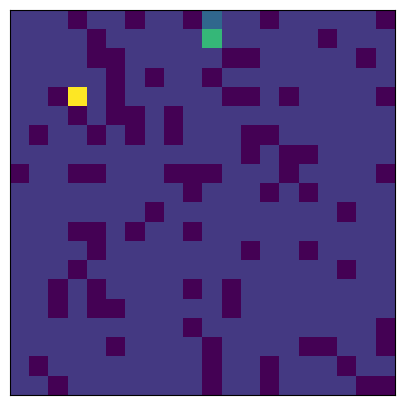

In [8]:
fig, axs = plt.subplots(figsize=(5,5))
axs.set_xticks([])
axs.set_yticks([])

cmap = plt.colormaps['viridis']

patch = plt.imshow(all_grid.iloc[0][0], cmap=cmap)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])

anim = animation.FuncAnimation(fig, animate, frames = iter_count)

In [9]:
anim

## Una corrida
- ¿Cuál es el tiempo necesario hasta que todas las celdas estén limpias?
  - Este modelo requirió 396 pasos para limpiar todo
- Empleando un número máximo de iteraciones, ¿cuál es el porcentaje de celdas limpias después del termino de la simulación?
- En ambos casos, ¿cuál es la cantidad de movimientos realizados por los agentes?

In [30]:
var_params = {"height": [5, 10, 20], "width": [5, 10, 20], "dirty_cell_percentage": [0.25, 0.5, 0.8]}
fixed_params = {"num_agents":  3}

batch_to_run = batchrunner.BatchRunner(
    VaccumCleanerModel,
    var_params,
    fixed_params,
    iterations = 5,
    max_steps = 600,
    model_reporters = {"Grid" : get_grid, "Clean": VaccumCleanerModel.all_clean}, 
    agent_reporters = {"Cleaned Cells": "clean_count","Paths": "visited_places"}
)

batch_to_run.run_all()

model_dict = batch_to_run.get_model_vars_dataframe()
agent_dict = batch_to_run.get_agent_vars_dataframe()


C:\Users\Felix\AppData\Local\Temp\ipykernel_19024\1946448384.py:4: DeprecationWarning: BatchRunner class has been replaced by batch_run function. Please see documentation.
  batch_to_run = batchrunner.BatchRunner(
135it [00:18,  7.38it/s]


In [38]:
model_dict

,height,width,dirty_cell_percentage,Run,Clean,Grid,num_agents
0,5,5,0.25,0,True,"[[2.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0....",3
1,5,5,0.25,1,True,"[[2.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0....",3
2,5,5,0.25,2,True,"[[2.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0....",3
3,5,5,0.25,3,True,"[[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0....",3
4,5,5,0.25,4,True,"[[2.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0....",3
...,...,...,...,...,...,...,...
130,20,20,0.80,130,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3
131,20,20,0.80,131,True,"[[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3
132,20,20,0.80,132,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3
133,20,20,0.80,133,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3


In [32]:
agent_dict

,height,width,dirty_cell_percentage,Run,AgentId,Cleaned Cells,Paths,num_agents
0,5,5,0.25,0,0,1,"[(0, 3), (0, 2), (0, 1), (0, 0), (1, 0), (1, 1...",3
1,5,5,0.25,0,1,4,"[(1, 4), (0, 4), (0, 3), (0, 2), (0, 1), (0, 0...",3
2,5,5,0.25,0,2,1,"[(0, 4), (0, 3), (0, 2), (0, 1), (0, 0), (1, 0...",3
3,5,5,0.25,1,0,3,"[(2, 2), (1, 2), (0, 2), (0, 1), (0, 0), (1, 0...",3
4,5,5,0.25,1,1,1,"[(0, 1), (0, 0), (1, 0), (1, 1), (1, 2), (0, 2...",3
...,...,...,...,...,...,...,...,...
399,20,20,0.80,133,0,42,"[(6, 14), (5, 14), (4, 14), (3, 14), (2, 14), ...",3
401,20,20,0.80,133,2,258,"[(4, 11), (3, 11), (2, 11), (1, 11), (0, 11), ...",3
403,20,20,0.80,134,1,118,"[(14, 8), (13, 8), (12, 8), (11, 8), (10, 8), ...",3
402,20,20,0.80,134,0,41,"[(5, 4), (4, 4), (3, 4), (2, 4), (1, 4), (0, 4...",3
